In [ ]:
%pip install upsetplot
import upsetplot
from upsetplot import from_memberships, plot
import csv
from itertools import combinations
import matplotlib

In [3]:
# Script to look at the genes predicted by MAKER and then identify those contigs in the pan-genome.
# Questions to answer: are any of the genes African- or population-specific?

# Set directory and file loactions:
genefile = "/cbio/projects/008/jess/HUPANrun/AfricanPanGenome/all/16_genepredfilter/data/Final/Final.gene.fasta"
clusterfile = "/cbio/projects/008/jess/HUPANrun/AfricanPanGenome/all/12_finalpangenome/cluster_info.txt"
populationfile = "ALLSAMPLES.csv"

# First, open gene file and make list of all the contigs
genecontigs = []
for line in open (genefile, 'r'):
    if ">" in line:
        splitline = line.split('\t')
        genecontigs.append(splitline[1].strip())

# Now go through the cluster file to find these contigs.
# Every time a ">" is encountered, a new list is made that contains all the clusters of interest.
# Then after we have all of them (should be 31 clusters) , we can identify the populations.

clusternames = []
geneclusters = []
for line in open (clusterfile, 'r'):
    if ">" in line:
        clusternames.append(line.strip())
    else:
        contigname = (line.split(" ")[1]).strip()
        if "*" in line and contigname in genecontigs:
            geneclusters.append(clusternames[-1])

print (geneclusters)
print (len(geneclusters)) # 31, correct

['>Cluster 99', '>Cluster 178', '>Cluster 397', '>Cluster 438', '>Cluster 895', '>Cluster 1133', '>Cluster 1244', '>Cluster 1253', '>Cluster 1361', '>Cluster 1533', '>Cluster 1889', '>Cluster 1955', '>Cluster 2823', '>Cluster 3778', '>Cluster 3861', '>Cluster 4209', '>Cluster 4719', '>Cluster 4771', '>Cluster 4936', '>Cluster 5039', '>Cluster 5772', '>Cluster 5794', '>Cluster 6857', '>Cluster 6931', '>Cluster 7349', '>Cluster 7959', '>Cluster 10517', '>Cluster 11605', '>Cluster 11750', '>Cluster 11820', '>Cluster 11910']
31


In [ ]:
with open (clusterfile, 'r') as clusters:
    alllines = clusters.readlines()

genefound = False
genedict = {}
poplist = []
for item in alllines:
    if ">" in item:
        if item.strip() in geneclusters:
            genefound = True
            poplist = []
            genedict[item.strip()] = poplist
            continue
        else:
            genefound = False
            if poplist: # check if poplist has items in it; if yes, add that to the last dictionary item
                dictkey = list(genedict.keys())[-1] # get the last dictionary key
                genedict[dictkey] = poplist
            poplist = []
            continue
        
    if genefound == True: # now we add all population IDs to a list
        sampleid = item.split(" ")[1].split(":")[0].strip()
        poplist.append(sampleid)
    
    else:
        continue
        
# print (genedict)
print (len(genedict)) # 31, correct

In [6]:
# Great! Now we will have to go through each item in the dict and identify the populations.
# For each gene, make a list of which populations have contributed to it.

# Read in each line in the sample file
file = open('ALLSAMPLES.csv', encoding = 'utf-8')
csv_metadata = csv.reader(file, delimiter = ',')
sampledata = list(csv_metadata)

# Create dict of populations and their samples
popdict = {}
for sample in sampledata[1:]:
    sampleid = sample[0].split(";")[0].strip()
    population = sample[0].split(";")[5].strip()
    popdict[sampleid] = population

# Iterate through gene dictionary and for each value, create a list of populations there
finaldict = {}
for key in genedict:
    sampleslist = genedict.get(key)
    
    popspresent = []
    for item in sampleslist:
        population = popdict.get(item)
        if population not in popspresent:
            popspresent.append(population)
    
    popspresent.sort()
    finaldict[key] = popspresent

print (finaldict)

{'>Cluster 99': ['BantuNC', 'CARF', 'CWNC', 'EAAA', 'EANS', 'FWNC', 'KhoeSan'], '>Cluster 178': ['BantuNC', 'CARF', 'CWNC', 'EAAA', 'EANS', 'FWNC', 'KhoeSan'], '>Cluster 397': ['BantuNC', 'CARF', 'FWNC', 'KhoeSan'], '>Cluster 438': ['BantuNC', 'CARF', 'FWNC'], '>Cluster 895': ['BantuNC', 'CARF', 'CWNC', 'EAAA', 'EANS', 'FWNC', 'KhoeSan'], '>Cluster 1133': ['BantuNC', 'KhoeSan'], '>Cluster 1244': ['BantuNC', 'CARF', 'CWNC', 'EAAA', 'EANS', 'FWNC', 'KhoeSan'], '>Cluster 1253': ['BantuNC', 'CARF', 'EANS', 'KhoeSan'], '>Cluster 1361': ['BantuNC', 'CARF', 'EANS', 'FWNC'], '>Cluster 1533': ['BantuNC', 'CARF', 'CWNC', 'EAAA', 'EANS', 'FWNC', 'KhoeSan'], '>Cluster 1889': ['BantuNC', 'CARF', 'CWNC', 'EANS', 'FWNC', 'KhoeSan'], '>Cluster 1955': ['CARF'], '>Cluster 2823': ['BantuNC', 'CWNC', 'EAAA', 'FWNC', 'KhoeSan'], '>Cluster 3778': ['BantuNC', 'EANS'], '>Cluster 3861': ['BantuNC', 'CARF', 'EAAA', 'EANS', 'KhoeSan'], '>Cluster 4209': ['BantuNC', 'CARF', 'EANS', 'FWNC'], '>Cluster 4719': ['CARF

In [ ]:
# Make upset plot as well

# Getting all the different intersections of populations.
combos = []
populations = ["BantuNC", "CARF", "CWNC", "EAAA", "EANS", "FWNC", "KhoeSan"]
for i in range(1,8):
    new = []
    new = list(combinations(populations, i))
    combos.extend(new)

# Now create a corresponding count list of all the intersection counts.
# Should be the same length.

counts = []
for intersection in combos:
    counts.append(0)

# Now go through each dict value, identify which index that is in the combos list and increase that value in the counts list
for value in finaldict.values():
    value = tuple(value)
    index = combos.index(value)
    counts[index] = counts[index] + 1

<ipython-input-10-a6b85905817e>:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('APGgenesUpset.svg', format='svg', dpi=1200)


<Figure size 432x288 with 0 Axes>

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


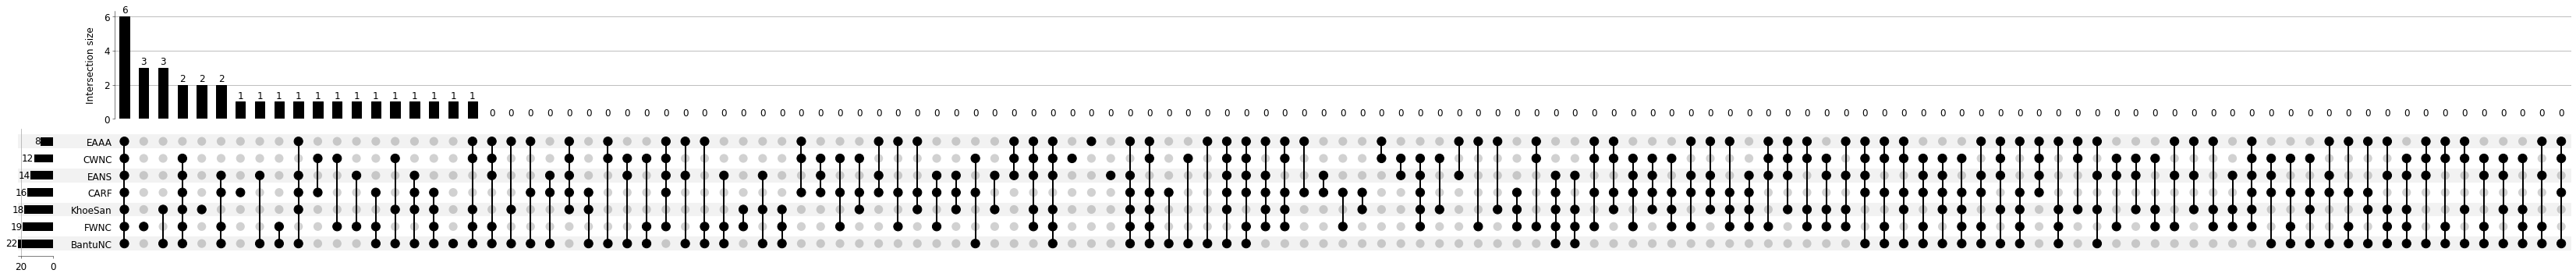

In [10]:
import matplotlib.pyplot as plt
plt.style.use("~/.matplotstyle/scientific.mplstyle")
fig1 = plt.figure()

upset = from_memberships(combos, counts)
plot(upset, sort_by='cardinality', show_counts=True)
# plt.savefig('APGgenesUpset.svg', format='svg', dpi=1200)